## Commodity co-movement diagnostics with nalyst 2.0.5

- **Author:** Hemant Thapa  
- **License:** MIT  
- **Python:** ≥ 3.10  

**Nalyst** is a full-stack machine learning toolkit with a unified `train()` / `infer()` API covering:
machine learning, statistics, time series, survival analysis, deep learning, AutoML, and explainability.

**Install:**
```bash
pip install nalyst==2.0.5
```

In [1]:
# load the libraries required for the nalyst validation workflow
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from nalyst.evaluation import train_test_split, cross_validate
from nalyst.learners.linear import OrdinaryLinearRegressor
from nalyst.metrics import root_mean_squared_error, r2_score
from nalyst.diagnostics import (
    residual_plots,
    influence_measures,
    outlier_test,
    het_breuschpagan,
    het_white,
    het_goldfeldquandt,
    durbin_watson,
    acorr_ljungbox,
    acorr_breusch_godfrey,
    variance_inflation_factor,
    condition_number,
    correlation_matrix,
    reset_test,
    harvey_collier,
)
from nalyst.diagnostics.specification import cusum_test
from nalyst.stats import shapiro, jarque_bera, anderson
from scipy import stats
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("error")

In [2]:
# check nalyst package metadata so we know the build context
from importlib.metadata import metadata, version

pkg = "nalyst"

print("Version:", version(pkg))

meta = metadata(pkg)
print("Author:", meta.get("Author"))
print("Author-email:", meta.get("Author-email"))

Version: 2.0.5
Author: Hemant Thapa
Author-email: hemantthapa1998@gmail.com


In [3]:
# download two commodities series (gold and crude oil) for the last year
gold = yf.download("GC=F", period="1Y", interval="1d", auto_adjust=False).copy()
crude = yf.download("CL=F", period="1Y", interval="1d", auto_adjust=False).copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


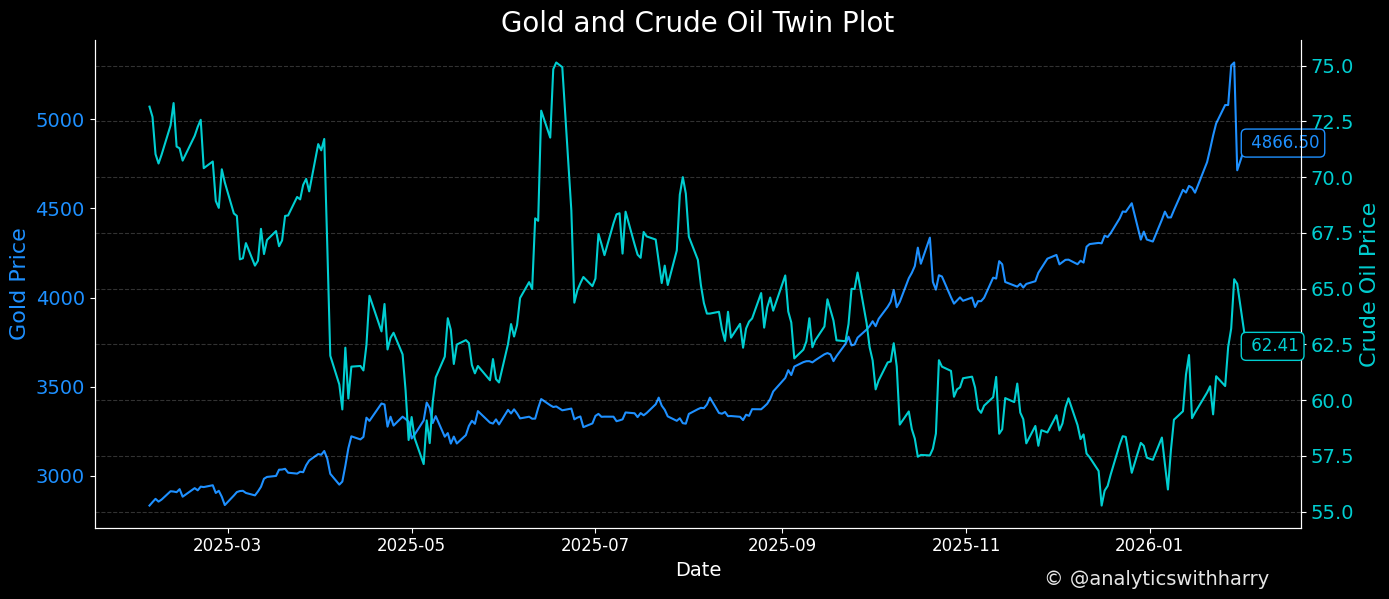

In [4]:
# plot both price series on twin axes for a quick visual comparison
def dual_axis_time_series(
    df1,
    df2,
    label1='Gold',
    label2='Crude Oil',
    color1='#1E90FF',
    color2='#00CED1',
    ylabel1='Gold Price',
    ylabel2='Crude Oil Price',
    title='Gold and Crude Oil Twin Plot',
    copyright_text='© @analyticswithharry',
    figsize=(14, 6)
    ):
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.set_xlabel('Date', fontsize=14, color='white')
    ax1.set_ylabel(ylabel1, color=color1, fontsize=16)
    ax1.plot(df1.index, df1['Close'], color=color1, lw=1.5, label=label1)
    ax1.tick_params(axis='y', labelcolor=color1, labelsize=14)
    ax1.tick_params(axis='x', labelcolor='white', labelsize=12)
    ax1.spines['top'].set_visible(False)

    ax2 = ax1.twinx()
    ax2.set_ylabel(ylabel2, color=color2, fontsize=16)
    ax2.plot(df2.index, df2['Close'], color=color2, lw=1.5, label=label2)
    ax2.tick_params(axis='y', labelcolor=color2, labelsize=14)
    ax2.spines['top'].set_visible(False)

    # latest price annotations
    latest_price1 = float(df1['Close'].iloc[-1].item() if hasattr(df1['Close'].iloc[-1], 'item') else df1['Close'].iloc[-1])
    latest_price2 = float(df2['Close'].iloc[-1].item() if hasattr(df2['Close'].iloc[-1], 'item') else df2['Close'].iloc[-1])
    ax1.text(df1.index[-1], latest_price1, f' {latest_price1:.2f}',
             verticalalignment='center', color=color1, fontsize=12,
             bbox=dict(facecolor='black', edgecolor=color1, boxstyle='round,pad=0.3'))
    ax2.text(df2.index[-1], latest_price2, f' {latest_price2:.2f}',
             verticalalignment='center', color=color2, fontsize=12,
             bbox=dict(facecolor='black', edgecolor=color2, boxstyle='round,pad=0.3'))

    plt.title(title, fontsize=20, color='white')
    plt.figtext(0.91, 0.01, copyright_text,
                ha='right', va='bottom', fontsize=14, color='white', alpha=0.9)
    plt.grid(True, axis='y', ls='--', alpha=0.2, color='white')
    fig.tight_layout()
    plt.show()

# render the twin-axis chart so we immediately see co-movement
dual_axis_time_series(gold, crude)

In [5]:
# define reusable indicators following nalyst-style helpers

def rsi(series: pd.Series, window: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0).fillna(0)
    loss = -delta.clip(upper=0).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def ema(series: pd.Series, window: int = 20) -> pd.Series:
    return series.ewm(span=window, adjust=False, min_periods=0).mean()

def sma(series: pd.Series, window: int = 20) -> pd.Series:
    return series.rolling(window=window, min_periods=0).mean()

In [6]:
# compute rsi plus moving-average overlays for both instruments
for label, df in {"Gold": gold, "Crude Oil": crude}.items():
    df.loc[:, "RSI"] = rsi(df["Close"], window=14)
    df.loc[:, "RSI_EMA_20"] = ema(df["RSI"], window=20)
    df.loc[:, "RSI_EMA_80"] = ema(df["RSI"], window=80)
    df.loc[:, "RSI_SMA_20"] = sma(df["RSI"], window=20)
    df.loc[:, "RSI_SMA_80"] = sma(df["RSI"], window=80)

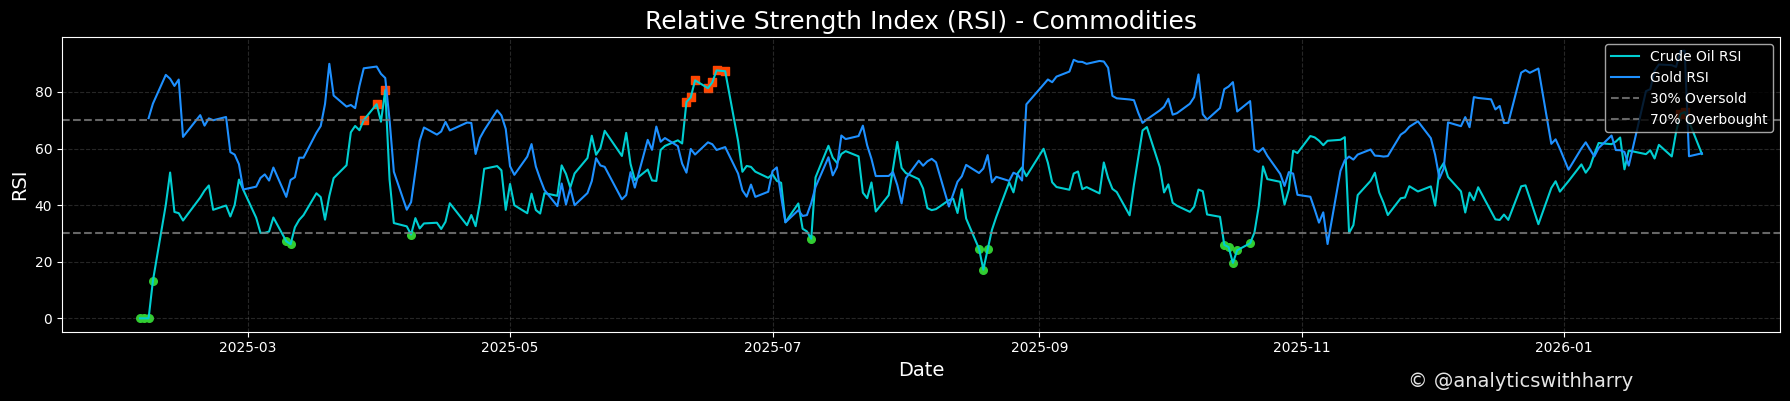

In [7]:
# visualize rsi for both series to spot joint momentum regimes
plt.style.use('dark_background')
plt.figure(figsize=(18, 4))
plt.plot(crude.index, crude['RSI'], label='Crude Oil RSI', color='#00CED1', lw=1.5)
plt.plot(gold.index, gold['RSI'], label='Gold RSI', color='#1E90FF', lw=1.5)
for index, rsi_value in crude['RSI'].items():
    if rsi_value <= 30:
        plt.scatter(index, rsi_value, color='#32CD32', marker='o', s=30)
    elif rsi_value >= 70:
        plt.scatter(index, rsi_value, color='#FF4500', marker='s', s=30)
plt.axhline(y=30, color='grey', linestyle='--', label='30% Oversold', alpha=0.8)
plt.axhline(y=70, color='grey', linestyle='--', label='70% Overbought', alpha=0.8)
plt.title('Relative Strength Index (RSI) - Commodities', fontsize=18, color='white')
plt.grid(True, ls='--', alpha=0.3, color='grey')
plt.xlabel('Date', fontsize=14, color='white')
plt.ylabel('RSI', fontsize=14, color='white')
plt.legend(loc='upper right')
plt.figtext(0.91, 0.01, '© @analyticswithharry',
            ha='right', va='bottom', fontsize=14, color='white', alpha=0.9)
plt.tight_layout()
plt.show()

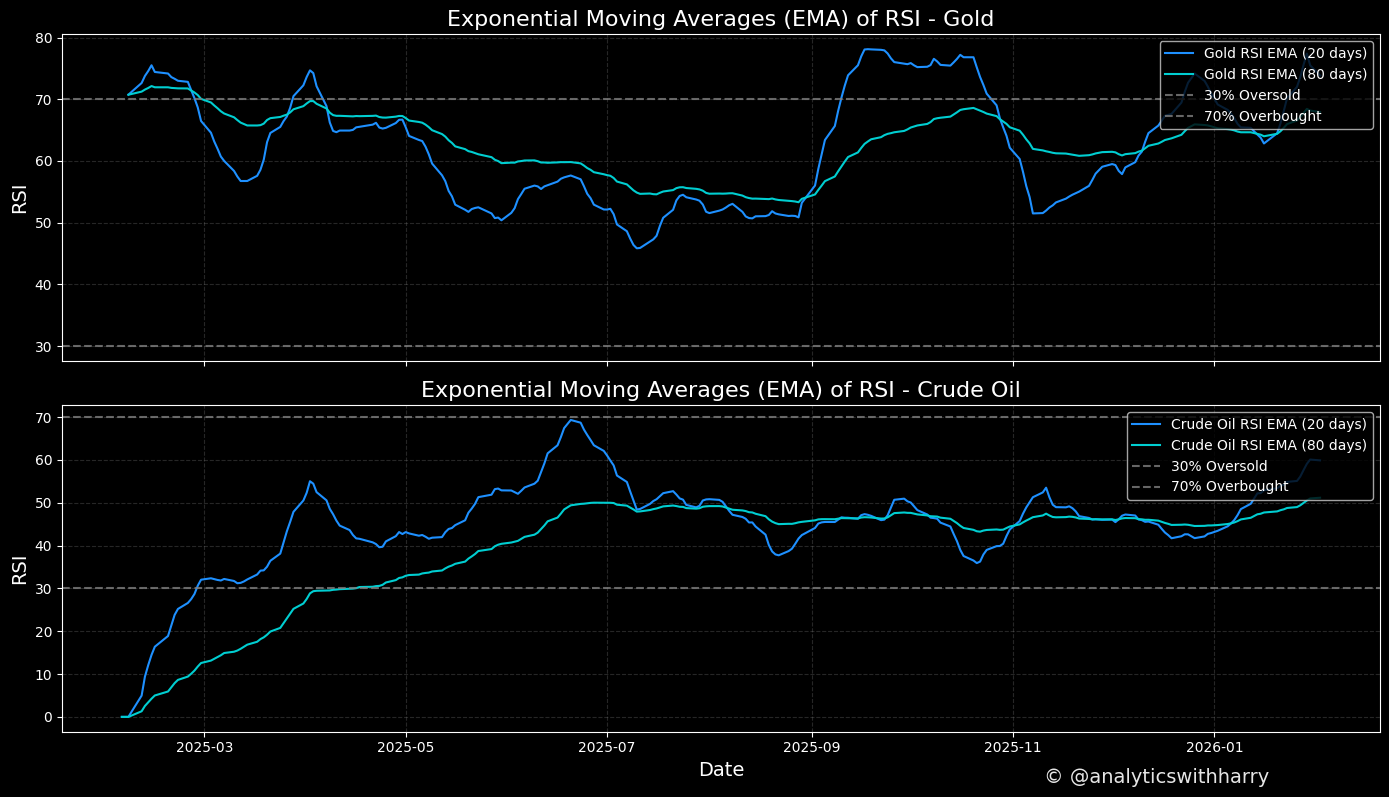

In [8]:
# add ema overlays on rsi to observe longer-term smooth signals
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(gold.index, gold['RSI_EMA_20'], label='Gold RSI EMA (20 days)', color='#1E90FF', lw=1.5)
ax1.plot(gold.index, gold['RSI_EMA_80'], label='Gold RSI EMA (80 days)', color='#00CED1', lw=1.5)
ax1.axhline(y=30, color='grey', linestyle='--', label='30% Oversold', alpha=0.8)
ax1.axhline(y=70, color='grey', linestyle='--', label='70% Overbought', alpha=0.8)
ax1.set_title('Exponential Moving Averages (EMA) of RSI - Gold', fontsize=16, color='white')
ax1.grid(True, ls='--', alpha=0.3, color='grey')
ax1.set_ylabel('RSI', fontsize=14, color='white')
ax1.legend(loc='upper right')

ax2.plot(crude.index, crude['RSI_EMA_20'], label='Crude Oil RSI EMA (20 days)', color='#1E90FF', lw=1.5)
ax2.plot(crude.index, crude['RSI_EMA_80'], label='Crude Oil RSI EMA (80 days)', color='#00CED1', lw=1.5)
ax2.axhline(y=30, color='grey', linestyle='--', label='30% Oversold', alpha=0.8)
ax2.axhline(y=70, color='grey', linestyle='--', label='70% Overbought', alpha=0.8)
ax2.set_title('Exponential Moving Averages (EMA) of RSI - Crude Oil', fontsize=16, color='white')
ax2.grid(True, ls='--', alpha=0.3, color='grey')
ax2.set_xlabel('Date', fontsize=14, color='white')
ax2.set_ylabel('RSI', fontsize=14, color='white')
ax2.legend(loc='upper right')

plt.figtext(0.91, 0.01, '© @analyticswithharry',
            ha='right', va='bottom', fontsize=14, color='white', alpha=0.9)
plt.tight_layout()
plt.show()

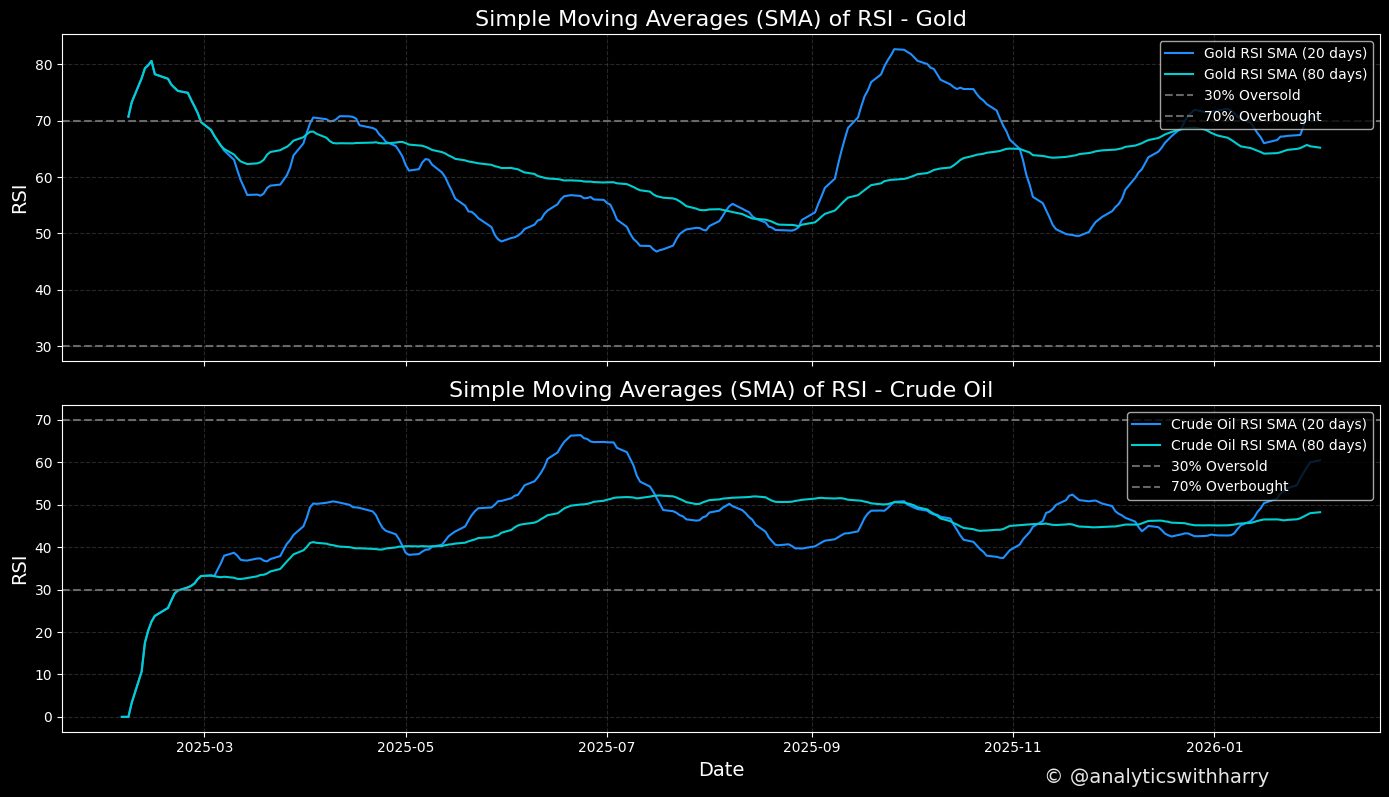

In [9]:
# repeat with sma overlays to contrast smoothing windows
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(gold.index, gold['RSI_SMA_20'], label='Gold RSI SMA (20 days)', color='#1E90FF', lw=1.5)
ax1.plot(gold.index, gold['RSI_SMA_80'], label='Gold RSI SMA (80 days)', color='#00CED1', lw=1.5)
ax1.axhline(y=30, color='grey', linestyle='--', label='30% Oversold', alpha=0.8)
ax1.axhline(y=70, color='grey', linestyle='--', label='70% Overbought', alpha=0.8)
ax1.set_title('Simple Moving Averages (SMA) of RSI - Gold', fontsize=16, color='white')
ax1.grid(True, ls='--', alpha=0.3, color='grey')
ax1.set_ylabel('RSI', fontsize=14, color='white')
ax1.legend(loc='upper right')

ax2.plot(crude.index, crude['RSI_SMA_20'], label='Crude Oil RSI SMA (20 days)', color='#1E90FF', lw=1.5)
ax2.plot(crude.index, crude['RSI_SMA_80'], label='Crude Oil RSI SMA (80 days)', color='#00CED1', lw=1.5)
ax2.axhline(y=30, color='grey', linestyle='--', label='30% Oversold', alpha=0.8)
ax2.axhline(y=70, color='grey', linestyle='--', label='70% Overbought', alpha=0.8)
ax2.set_title('Simple Moving Averages (SMA) of RSI - Crude Oil', fontsize=16, color='white')
ax2.grid(True, ls='--', alpha=0.3, color='grey')
ax2.set_xlabel('Date', fontsize=14, color='white')
ax2.set_ylabel('RSI', fontsize=14, color='white')
ax2.legend(loc='upper right')

plt.figtext(0.91, 0.01, '© @analyticswithharry',
            ha='right', va='bottom', fontsize=14, color='white', alpha=0.9)
plt.tight_layout()
plt.show()

In [10]:
# engineer polynomial features that nalyst learners can use downstream
print(type(gold["Adj Close"]), gold["Adj Close"].shape)
print(type(crude["Adj Close"]), crude["Adj Close"].shape)
print(gold["Adj Close"].head())
print(crude["Adj Close"].head())

# align on dates and drop missing values to avoid nans/inf
aligned = pd.concat([gold["Adj Close"], crude["Adj Close"]], axis=1, keys=["gold", "crude"]).dropna()

X = aligned["gold"].to_numpy().reshape(-1, 1)
y = aligned["crude"].to_numpy()
print("Aligned shapes:", X.shape, y.shape)

def make_poly_features(x: np.ndarray, degree: int = 5) -> np.ndarray:
    x = np.asarray(x).ravel()
    return np.vander(x, N=6, increasing=True)  # degree 5 + bias

X_poly = make_poly_features(X, degree=5)

<class 'pandas.core.frame.DataFrame'> (252, 1)
<class 'pandas.core.frame.DataFrame'> (252, 1)
Ticker             GC=F
Date                   
2025-02-03  2833.899902
2025-02-04  2853.300049
2025-02-05  2871.600098
2025-02-06  2856.000000
2025-02-07  2867.300049
Ticker           CL=F
Date                 
2025-02-03  73.160004
2025-02-04  72.699997
2025-02-05  71.029999
2025-02-06  70.610001
2025-02-07  71.000000
Aligned shapes: (252, 1) (252, 1)


In [11]:
# split the data and fit the ordinary linear regressor
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
model = OrdinaryLinearRegressor()
model.train(X_train, y_train)
print("Coefficients learned (first 3):", model.coef_[:3], "...")

Coefficients learned (first 3): [ 0.00000000e+00 -2.15027417e-08 -3.53538195e-05] ...


In [12]:
# evaluate rmse and r² on the holdout split
y_pred_train = model.infer(X_train)
y_pred_test = model.infer(X_test)

train_rmse = root_mean_squared_error(y_train, y_pred_train)
test_rmse = root_mean_squared_error(y_test, y_pred_test)

# ensure 1d arrays for r2_score to avoid index errors
if y_pred_train.ndim > 1 and y_pred_train.shape[1] == 1:
    y_pred_train = y_pred_train.ravel()
if y_pred_test.ndim > 1 and y_pred_test.shape[1] == 1:
    y_pred_test = y_pred_test.ravel()
if y_train.ndim > 1 and y_train.shape[1] == 1:
    y_train = y_train.ravel()
if y_test.ndim > 1 and y_test.shape[1] == 1:
    y_test = y_test.ravel()

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

summary = [
    ["Train", train_rmse, train_r2],
    ["Test", test_rmse, test_r2],
]
print(tabulate(summary, headers=["Split", "RMSE", "R^2"], floatfmt=".4f"))

Split      RMSE     R^2
-------  ------  ------
Train    5.4441  0.5591
Test     5.4068  0.5961


In [13]:
# run cross-validation so we get distributional performance estimates

def neg_rmse_scorer(y_true, y_pred):
    """return negative rmse because nalyst maximizes the score."""
    return -root_mean_squared_error(y_true, y_pred)


def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)


cv_rmse = cross_validate(
    model,
    X_poly,
    y,
    scoring=neg_rmse_scorer,
    cv=5,
    return_train_score=True,
    n_jobs=1,
)

cv_r2 = cross_validate(
    model,
    X_poly,
    y,
    scoring=r2_scorer,
    cv=5,
    return_train_score=True,
    n_jobs=1,
)

cv_table = pd.DataFrame({
    "Fold": np.arange(1, len(cv_rmse["test_score"]) + 1),
    "RMSE": -cv_rmse["test_score"],
    "Train_RMSE": -cv_rmse["train_score"],
    "R2": cv_r2["test_score"],
    "Train_R2": cv_r2["train_score"],
    "Fit_Time(s)": cv_rmse["fit_time"],
    "Score_Time(s)": cv_rmse["score_time"],
})

print(tabulate(cv_table, headers="keys", tablefmt="github", floatfmt=".4f"))
print(
    f"\nRMSE CV mean ± std: {cv_table['RMSE'].mean():.4f} ± {cv_table['RMSE'].std(ddof=1):.4f}"
)
print(
    f"R² CV mean ± std: {cv_table['R2'].mean():.4f} ± {cv_table['R2'].std(ddof=1):.4f}"
)


|    |   Fold |    RMSE |   Train_RMSE |   R2 |   Train_R2 |   Fit_Time(s) |   Score_Time(s) |
|----|--------|---------|--------------|------|------------|---------------|-----------------|
|  0 | 1.0000 | 16.1054 |       4.5409 |  nan |        nan |        0.0004 |          0.0003 |
|  1 | 2.0000 |  4.6971 |       5.7893 |  nan |        nan |        0.0002 |          0.0001 |
|  2 | 3.0000 |  2.7617 |       5.7806 |  nan |        nan |        0.0002 |          0.0001 |
|  3 | 4.0000 |  2.5492 |       5.5783 |  nan |        nan |        0.0002 |          0.0001 |
|  4 | 5.0000 | 21.7491 |       4.7953 |  nan |        nan |        0.0004 |          0.0001 |

RMSE CV mean ± std: 9.5725 ± 8.8095
R² CV mean ± std: nan ± nan


X shape: (252, 1)
y shape: (252, 1)
X_sorted shape: (252, 1)
X_poly_sorted shape: (252, 6)
pred_sorted shape: (252,)


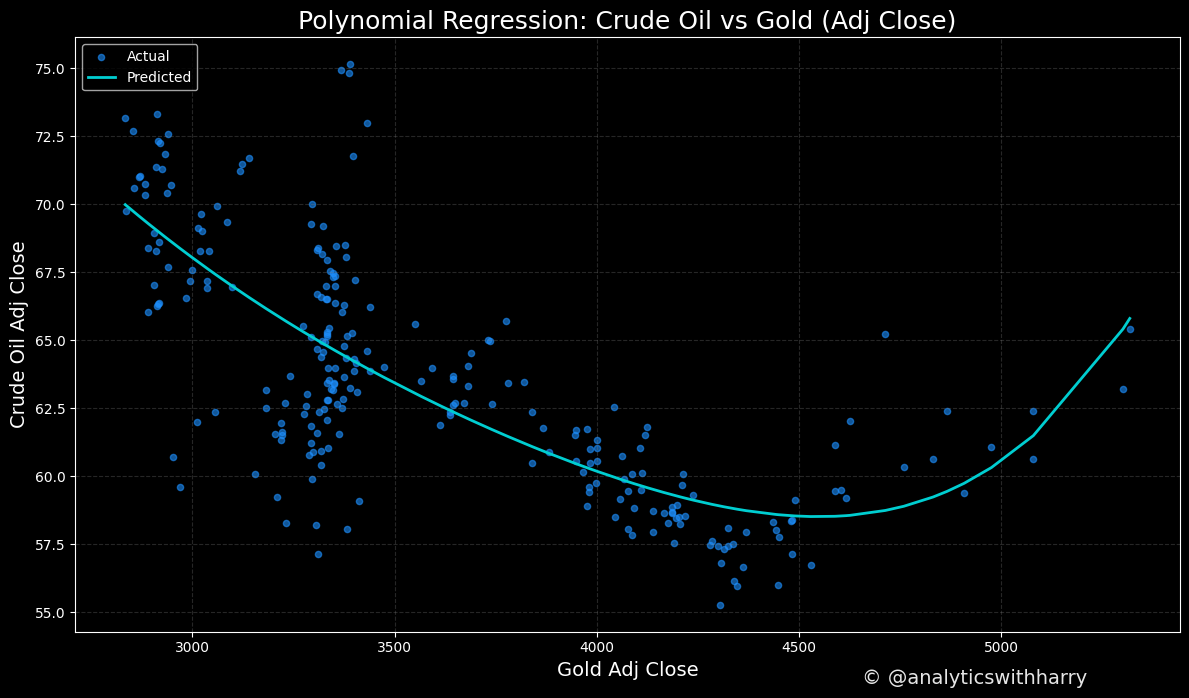

In [14]:
# visualize the polynomial fit against sorted gold prices
print("X shape:", X.shape)
print("y shape:", y.shape)
sorted_idx = np.argsort(X.ravel())
X_sorted = X[sorted_idx]
print("X_sorted shape:", X_sorted.shape)
X_poly_sorted = make_poly_features(X_sorted, degree=5)
print("X_poly_sorted shape:", X_poly_sorted.shape)
pred_sorted = model.infer(X_poly_sorted)
print("pred_sorted shape:", pred_sorted.shape)

plt.style.use('dark_background')
plt.figure(figsize=(12, 7))
plt.scatter(X, y, color="#1E90FF", alpha=0.6, label="Actual", s=20)
plt.plot(X_sorted, pred_sorted, color="#00CED1", lw=2, label="Predicted")
plt.title("Polynomial Regression: Crude Oil vs Gold (Adj Close)", fontsize=18, color='white')
plt.xlabel("Gold Adj Close", fontsize=14, color='white')
plt.ylabel("Crude Oil Adj Close", fontsize=14, color='white')
plt.grid(True, ls="--", alpha=0.3, color='grey')
plt.legend(loc='upper left')
plt.figtext(0.91, 0.01, '© @analyticswithharry',
            ha='right', va='bottom', fontsize=14, color='white', alpha=0.9)
plt.tight_layout()
plt.show()

X shape: (252, 1)
y shape: (252, 1)
residuals shape: (252,)
X_flat shape: (252,)


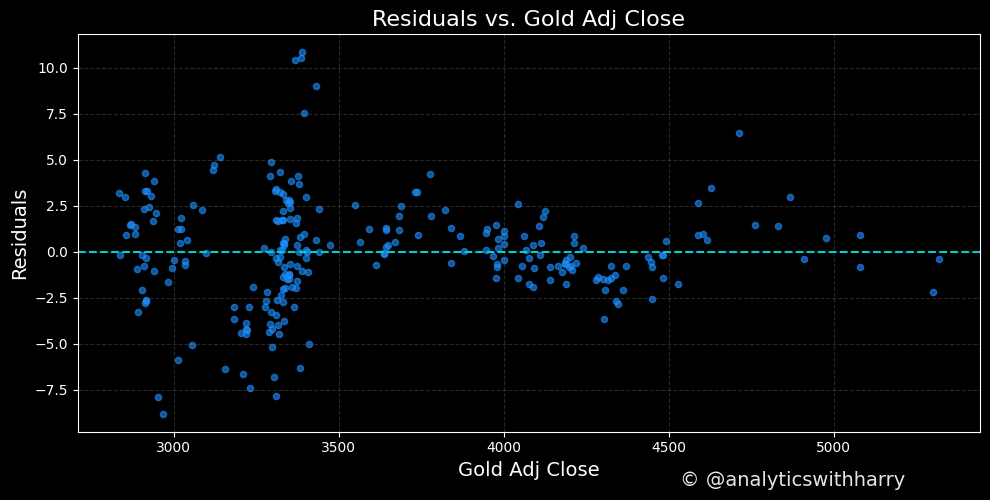

In [15]:
# inspect residuals against predictors before formal diagnostics
# compute residuals from the full dataset
y_pred_all = model.infer(X_poly)
if y_pred_all.ndim > 1 and y_pred_all.shape[1] == 1:
    y_pred_all = y_pred_all.ravel()
y_flat = y.ravel() if y.ndim > 1 else y
residuals = y_flat - y_pred_all

print("X shape:", X.shape)
print("y shape:", y.shape)
print("residuals shape:", residuals.shape)

# flatten x if needed for scatter plot
X_flat = X.ravel() if X.ndim > 1 and X.shape[1] == 1 else X
print("X_flat shape:", X_flat.shape)

plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.scatter(X_flat, residuals, color="#1E90FF", alpha=0.6, s=20)
plt.axhline(0, color="#00CED1", linestyle="--", lw=1.5)
plt.title("Residuals vs. Gold Adj Close", fontsize=16, color='white')
plt.xlabel("Gold Adj Close", fontsize=14, color='white')
plt.ylabel("Residuals", fontsize=14, color='white')
plt.grid(True, ls="--", alpha=0.3, color='grey')
plt.figtext(0.91, 0.01, '© @analyticswithharry',
            ha='right', va='bottom', fontsize=14, color='white', alpha=0.9)
plt.tight_layout()
plt.show()

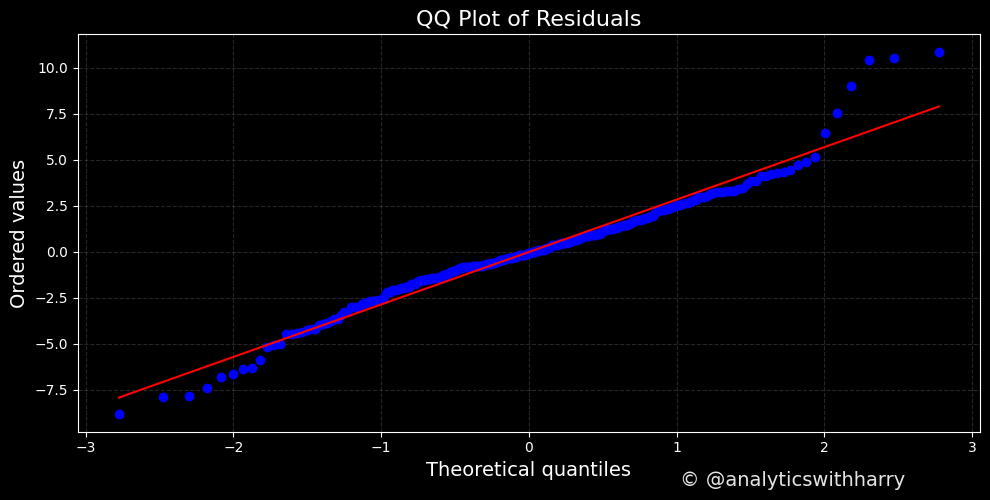

In [16]:
# draw a qq plot so deviations from normality are obvious
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals", fontsize=16, color='white')
plt.xlabel("Theoretical quantiles", fontsize=14, color='white')
plt.ylabel("Ordered values", fontsize=14, color='white')
plt.grid(True, ls="--", alpha=0.3, color='grey')
plt.figtext(0.91, 0.01, '© @analyticswithharry',
            ha='right', va='bottom', fontsize=14, color='white', alpha=0.9)
plt.tight_layout()
plt.show()

In [17]:
# extract nalyst residual diagnostics to quantify leverage and influence
y_all = y.ravel() if y.ndim > 1 else y
X_design = X_poly.copy()
y_pred_full = model.infer(X_design).ravel()
residuals = y_all - y_pred_full

res_diag = residual_plots(y_all, y_pred_full, X_design)
infl_diag = influence_measures(y_all, X_design)
outlier_diag = outlier_test(y_all, X_design, alpha=0.05)

leverage_threshold = 2 * X_design.shape[1] / X_design.shape[0]
leverage_flags = np.where(res_diag["leverage"] > leverage_threshold)[0]
cooks_threshold = 4 / len(y_all)
cooks_flags = np.where(res_diag["cooks_distance"] > cooks_threshold)[0]

diag_rows = [
    ["Max |std residual|", np.max(np.abs(res_diag["standardized_residuals"]))],
    ["Max leverage", np.max(res_diag["leverage"])],
    ["Max Cook's D", np.max(res_diag["cooks_distance"])],
    ["Max |DFFITS|", np.max(np.abs(res_diag["dffits"]))],
    ["Outlier critical |t|", outlier_diag["critical_value"]],
    ["Detected outliers", outlier_diag["outliers"].size],
]

print(tabulate(diag_rows, headers=["Diagnostic", "Value"], tablefmt="github", floatfmt=".4f"))

if leverage_flags.size:
    print(f"High leverage points (> {leverage_threshold:.3f}): {leverage_flags.tolist()}")
else:
    print("No high leverage points beyond the 2k/n rule-of-thumb.")

if cooks_flags.size:
    print(f"Cook's distance flags (> {cooks_threshold:.3f}): {cooks_flags.tolist()}")
else:
    print("No influential points beyond the 4/n Cook's distance heuristic.")

if outlier_diag["outliers"].size:
    print(f"Bonferroni-corrected outliers (α=0.05): {outlier_diag['outliers'].tolist()}")
else:
    print("No statistically significant outliers at α=0.05 with Bonferroni correction.")


| Diagnostic           |   Value |
|----------------------|---------|
| Max |std residual|   |  3.7542 |
| Max leverage         |  0.5037 |
| Max Cook's D         |  0.1229 |
| Max |DFFITS|         |  0.8589 |
| Outlier critical |t| |  3.7782 |
| Detected outliers    |  2.0000 |
High leverage points (> 0.048): [0, 1, 3, 4, 18, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
Cook's distance flags (> 0.016): [0, 44, 45, 91, 93, 94, 95, 248, 250, 251]
Bonferroni-corrected outliers (α=0.05): [248, 249]


In [18]:
# run nalyst normality tests to see if residuals are gaussian
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    shapiro_stat, shapiro_p = shapiro(residuals)

jb_stat, jb_p = jarque_bera(residuals)
anderson_res = anderson(residuals)

anderson_stat = anderson_res["statistic"]
anderson_crit_5 = anderson_res["critical_values"][2]
anderson_decision = "Fail" if anderson_stat > anderson_crit_5 else "Pass"

normality_rows = [
    ["Shapiro-Wilk", shapiro_stat, shapiro_p, "Fail" if shapiro_p < 0.05 else "Pass"],
    ["Jarque-Bera", jb_stat, jb_p, "Fail" if jb_p < 0.05 else "Pass"],
    ["Anderson-Darling (5%)", anderson_stat, anderson_crit_5, anderson_decision],
]

print(tabulate(normality_rows, headers=["Test", "Statistic", "p / crit", "Decision"], tablefmt="github", floatfmt=".4f"))


| Test                  |   Statistic |   p / crit | Decision   |
|-----------------------|-------------|------------|------------|
| Shapiro-Wilk          |      0.9620 |     0.5000 | Pass       |
| Jarque-Bera           |     50.3933 |     0.0000 | Fail       |
| Anderson-Darling (5%) |      2.0101 |     0.7870 | Fail       |


In [19]:
# test for heteroscedasticity with multiple nalyst procedures
bp_lm, bp_lm_p, bp_f, bp_f_p = het_breuschpagan(residuals, X_design)
white_lm, white_lm_p, white_f, white_f_p = het_white(residuals, X_design)
gq_f, gq_p, gq_order = het_goldfeldquandt(y_all, X_design)

hetero_rows = [
    ["Breusch-Pagan LM", bp_lm, bp_lm_p, "Fail" if bp_lm_p < 0.05 else "Pass"],
    ["Breusch-Pagan F", bp_f, bp_f_p, "Fail" if bp_f_p < 0.05 else "Pass"],
    ["White LM", white_lm, white_lm_p, "Fail" if white_lm_p < 0.05 else "Pass"],
    ["White F", white_f, white_f_p, "Fail" if white_f_p < 0.05 else "Pass"],
    [f"Goldfeld-Quandt ({gq_order})", gq_f, gq_p, "Fail" if gq_p < 0.05 else "Pass"],
]

print(tabulate(hetero_rows, headers=["Test", "Statistic", "p-value", "Decision"], tablefmt="github", floatfmt=".4f"))


| Test                         |   Statistic |   p-value | Decision   |
|------------------------------|-------------|-----------|------------|
| Breusch-Pagan LM             |     13.7768 |    0.0171 | Fail       |
| Breusch-Pagan F              |      2.8480 |    0.0161 | Fail       |
| White LM                     |     13.7686 |    0.8420 | Pass       |
| White F                      |      0.6037 |    0.9082 | Pass       |
| Goldfeld-Quandt (decreasing) |      0.3996 |    0.0000 | Fail       |


In [20]:
# check residual autocorrelation via durbin-watson, ljung-box, and breusch-godfrey
dw_stat = durbin_watson(residuals)
ljung = acorr_ljungbox(residuals, lags=10)
bg_lm, bg_lm_p, bg_f, bg_f_p = acorr_breusch_godfrey(residuals, X_design, nlags=5)

auto_rows = [
    ["Durbin-Watson", dw_stat, np.nan, "Potential" if (dw_stat < 1.5 or dw_stat > 2.5) else "OK"],
    ["Breusch-Godfrey LM", bg_lm, bg_lm_p, "Fail" if bg_lm_p < 0.05 else "Pass"],
    ["Breusch-Godfrey F", bg_f, bg_f_p, "Fail" if bg_f_p < 0.05 else "Pass"],
]

print(tabulate(auto_rows, headers=["Test", "Statistic", "p-value", "Decision"], tablefmt="github", floatfmt=".4f"))

ljung_table = pd.DataFrame({
    "Lag": ljung["lags"],
    "LB_Stat": ljung["lb_stat"],
    "p-value": ljung["lb_pvalue"],
})
print("\nLjung-Box per-lag summary:")
print(tabulate(ljung_table, headers="keys", tablefmt="github", floatfmt=".4f"))


| Test               |   Statistic |   p-value | Decision   |
|--------------------|-------------|-----------|------------|
| Durbin-Watson      |      0.2637 |  nan      | Potential  |
| Breusch-Godfrey LM |      0.1276 |    0.9997 | Pass       |
| Breusch-Godfrey F  |      0.0244 |    0.9997 | Pass       |

Ljung-Box per-lag summary:
|    |     Lag |   LB_Stat |   p-value |
|----|---------|-----------|-----------|
|  0 |  1.0000 |  190.1788 |    0.0000 |
|  1 |  2.0000 |  324.6567 |    0.0000 |
|  2 |  3.0000 |  414.6758 |    0.0000 |
|  3 |  4.0000 |  474.9476 |    0.0000 |
|  4 |  5.0000 |  515.3564 |    0.0000 |
|  5 |  6.0000 |  540.9585 |    0.0000 |
|  6 |  7.0000 |  557.5597 |    0.0000 |
|  7 |  8.0000 |  569.3107 |    0.0000 |
|  8 |  9.0000 |  577.0313 |    0.0000 |
|  9 | 10.0000 |  584.3446 |    0.0000 |


In [21]:
# probe model specification and stability with reset, harvey-collier, and cusum
reset_f, reset_p = reset_test(y_all, X_design)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    hc_t, hc_p = harvey_collier(y_all, X_design)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    cusum_res = cusum_test(y_all, X_design)

spec_rows = [
    ["Ramsey RESET", reset_f, reset_p, "Fail" if reset_p < 0.05 else "Pass"],
    ["Harvey-Collier", hc_t, hc_p, "Fail" if hc_p < 0.05 else "Pass"],
    ["CUSUM", cusum_res.get("statistic"), cusum_res.get("pvalue"), "Fail" if cusum_res.get("pvalue", 1) < 0.05 else "Pass"],
]

print(tabulate(spec_rows, headers=["Test", "Statistic", "p-value", "Decision"], tablefmt="github", floatfmt=".4f"))


| Test           |   Statistic |   p-value | Decision   |
|----------------|-------------|-----------|------------|
| Ramsey RESET   |    138.4269 |    0.0000 | Fail       |
| Harvey-Collier |      0.9722 |    0.3319 | Pass       |
| CUSUM          |    nan      |  nan      | Pass       |


In [22]:
# examine multicollinearity via vif, condition number, and correlation matrix
feature_labels = [f"gold_power_{deg}" for deg in range(1, X_design.shape[1])]
vif_values = variance_inflation_factor(X_design)
vif_table = pd.DataFrame({
    "Feature": feature_labels,
    "VIF": np.atleast_1d(vif_values),
})

cond_num = condition_number(X_design)
corr_mat = pd.DataFrame(
    correlation_matrix(X_design),
    index=feature_labels,
    columns=feature_labels,
)

print(tabulate(vif_table, headers="keys", tablefmt="github", floatfmt=".4f"))
print(f"\nDesign matrix condition number: {cond_num:.2f}")
print("\nFeature correlation matrix:")
print(tabulate(corr_mat, headers="keys", tablefmt="github", floatfmt=".2f"))


|    | Feature      |          VIF |
|----|--------------|--------------|
|  0 | gold_power_1 |      87.0571 |
|  1 | gold_power_2 |    5462.6126 |
|  2 | gold_power_3 |  106686.0248 |
|  3 | gold_power_4 |  186104.2528 |
|  4 | gold_power_5 | 1171967.6008 |

Design matrix condition number: 142193.01

Feature correlation matrix:
|              |   gold_power_1 |   gold_power_2 |   gold_power_3 |   gold_power_4 |   gold_power_5 |
|--------------|----------------|----------------|----------------|----------------|----------------|
| gold_power_1 |           1.00 |           1.00 |           0.99 |           0.97 |           0.95 |
| gold_power_2 |           1.00 |           1.00 |           1.00 |           0.99 |           0.97 |
| gold_power_3 |           0.99 |           1.00 |           1.00 |           1.00 |           0.99 |
| gold_power_4 |           0.97 |           0.99 |           1.00 |           1.00 |           1.00 |
| gold_power_5 |           0.95 |           0.97 |       